In [1]:
# Source : https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

# Adapted version for MNIST and Pytorch

import torch
import torch.nn.functional as F
from torch import nn 

import torchvision.datasets as datasets
from tqdm import tqdm 
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch import optim

c:\Users\ps1109\AppData\Local\Continuum\Anaconda3\envs\torch\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
DEVICE = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 2
NUM_EPOCHS  = 500
BATCH_SIZE = 32
LR_RATE = 1e-4

In [3]:
def gaussian_likelihood(x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim= 1,  latent_dim = 20) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.activation = nn.ReLU()
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=3, stride=2, padding = 0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=2, padding = 1)
        self.linear_mu = nn.Linear(3136, self.latent_dim)
        self.linear_sigma = nn.Linear(3136, self.latent_dim)
        
        self.Linear1 = nn.Linear(self.latent_dim, 32* 7* 7)
        self.deconv1 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1, padding=0)
        # Decoder Layesr 
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = x.view(x.shape[0], -1)
        mu = self.linear_mu(x)
        x_sigma = self.linear_sigma(x)

        # sample z from q
        std = torch.exp(x_sigma / 2)
        q = torch.distributions.Normal(mu, std)
        z= q.rsample()
        
        x = self.Linear1(z)
        x = x.view(x.shape[0], 32, 7, 7)
        x = self.activation(self.deconv1(x))
        x = self.activation(self.deconv2(x))
        x_hat = self.activation(self.deconv3(x))
        return x_hat, z, mu, std, self.log_scale

In [5]:
dataset = datasets.MNIST(root = "dataset/", train = True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = dataset, batch_size = BATCH_SIZE, shuffle=True)
model = VariationalAutoencoder(input_dim= 1,  latent_dim = Z_DIM).to(device=DEVICE)
optimizer = optim.Adam(model.parameters(), lr =  LR_RATE)
loss_fn = nn.BCELoss(reduce="sum")

c:\Users\ps1109\AppData\Local\Continuum\Anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [6]:


for epoch in tqdm(range(NUM_EPOCHS)):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        x = x.to(DEVICE)
        x_hat, z, mu, std, log_scale = model(x)

        # Compute Loss 
        reconstruction_loss = gaussian_likelihood(x_hat,log_scale, x)
        kl_div =  kl_divergence(z, mu, std)
        
        # Backprop
        loss = kl_div - reconstruction_loss 
        elbo = loss.mean()
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        loop.set_postfix(loss = elbo.item())

1875it [01:32, 20.29it/s, loss=612]t/s]
1875it [01:25, 21.88it/s, loss=485]:31, 92.41s/it]
1875it [01:25, 22.01it/s, loss=368]:12, 88.46s/it]
1875it [01:22, 22.72it/s, loss=255]:22, 86.97s/it]
1875it [01:30, 20.65it/s, loss=179]:27, 85.22s/it]
1875it [01:22, 22.69it/s, loss=101]:37, 87.23s/it]
1875it [01:20, 23.41it/s, loss=46.6]20, 85.67s/it]
1875it [01:31, 20.46it/s, loss=46.8]58, 83.85s/it]
1875it [01:28, 21.24it/s, loss=0.375]2, 86.33s/it]
1875it [01:35, 19.59it/s, loss=60.5]24, 86.93s/it]
1875it [01:26, 21.63it/s, loss=51.1]:08, 89.65s/it]
1875it [01:30, 20.61it/s, loss=8.88]:15, 88.74s/it]
1875it [01:31, 20.43it/s, loss=-23.1]20, 89.43s/it]
1875it [01:28, 21.23it/s, loss=15.6]:36, 90.14s/it]
1875it [01:33, 20.13it/s, loss=27.2]:41, 89.59s/it]
1875it [01:32, 20.19it/s, loss=18.1]:54, 90.67s/it]
1875it [01:25, 21.90it/s, loss=21.5]:41, 91.33s/it]
1875it [01:29, 21.02it/s, loss=10.9]:22, 89.61s/it]
1875it [01:26, 21.78it/s, loss=3.57]:56, 89.50s/it]
1875it [01:29, 20.88it/s, loss=71

In [7]:
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
valid_dataset = datasets.MNIST(root = "dataset/", train = False, transform=transforms.ToTensor(), download=True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle=True)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()

        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def infer_batch(valid_loader):
    valid_loader_iter = iter(valid_loader)
    (x, _) = next(valid_loader_iter)
    x = x.to(DEVICE)
    x_hat, z, mu, std, log_scale = model(x)

    grid = make_grid(x_hat)
    show(grid)

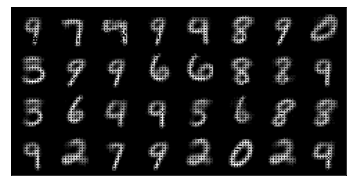

In [8]:
infer_batch(valid_loader)